In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import shutil
import time

from dotenv import load_dotenv
load_dotenv()

from pyvo.dal import sia
from dl import authClient as ac

from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb, simple_norm
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats

from reproject import reproject_interp
from photutils.aperture import SkyCircularAperture
import warnings
warnings.filterwarnings("ignore")

from photutils.detection import DAOStarFinder

# Init

In [9]:
token = ac.login(os.getenv('DATALAB_LOGIN'), os.getenv('DATALAB_PASSWORD'))
token

'helgy716.1927.1927.$1$.eZwLhFD$oX5qjpInYsoQowagYSQdc1'

In [10]:
# The default endpoint points to the entire public Astro Data Archive
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

# Load Tables of observations

In [5]:
df_candidates = pd.read_csv('data/candidates/candidates2.csv')
gr = df_candidates.groupby('source_id_smss')
fov = 30.0/3600 # in degrees

In [6]:
coords = SkyCoord(ra=gr['ra_smss'].mean(), dec=gr['dec_smss'].mean(), unit=(u.deg, u.deg))
idx, d2d, _ = coords.match_to_catalog_sky(coords, nthneighbor=2)
mask = d2d < 3 * u.arcsec
print(f"{mask.sum()} sources have a nearby neighbour")

274 sources have a nearby neighbour


In [11]:
start, width = 5950, 2000
for i, source_id in enumerate(list(gr.groups.keys())[start:start+width]):
    group = gr.get_group(source_id)
    if i < 0:
        continue
    fname = f'data/candidates/tables2/{source_id}.csv'
    if os.path.exists(fname):
        print(f'Skipping {source_id} ({i+1}/{len(gr)}) as file already exists')
        continue

    print(f'Processing {source_id} ({i+1}/{len(gr)})', time.ctime())
    ra = group['ra_smss'].values[0]
    dec = group['dec_smss'].values[0]
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    imgTable.to_pandas().to_csv(fname, index=False)

Processing 232457927 (1/13576) Wed Dec  4 12:17:30 2024
Processing 232458471 (2/13576) Wed Dec  4 12:17:32 2024
Processing 232478542 (3/13576) Wed Dec  4 12:17:34 2024
Processing 232482858 (4/13576) Wed Dec  4 12:17:36 2024
Processing 232514444 (5/13576) Wed Dec  4 12:17:37 2024
Processing 232535656 (6/13576) Wed Dec  4 12:17:39 2024
Processing 232538387 (7/13576) Wed Dec  4 12:17:41 2024
Processing 232589571 (8/13576) Wed Dec  4 12:17:43 2024
Processing 232599276 (9/13576) Wed Dec  4 12:17:45 2024
Processing 232612951 (10/13576) Wed Dec  4 12:17:47 2024
Processing 232649960 (11/13576) Wed Dec  4 12:17:48 2024
Processing 232652857 (12/13576) Wed Dec  4 12:17:50 2024
Processing 232683547 (13/13576) Wed Dec  4 12:17:51 2024
Processing 232683798 (14/13576) Wed Dec  4 12:17:53 2024
Processing 232812334 (15/13576) Wed Dec  4 12:17:55 2024
Processing 232815204 (16/13576) Wed Dec  4 12:17:58 2024
Processing 232818248 (17/13576) Wed Dec  4 12:18:00 2024
Processing 232818679 (18/13576) Wed Dec 

KeyboardInterrupt: 

In [ ]:
# df=imgTable.to_pandas()
# df

# Load images

In [ ]:
# A little function to download the deepest stacked images
def download_deepest_image(ra,dec,svc=sia.SIAService('https://datalab.noirlab.edu/sia'),
                           fov=30.0/3600, imgTable=None, band='r'):
    if imgTable is None:
        imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table().to_pandas()
    
    sel0 = imgTable['obs_bandpass'].astype(str) == band
    print("The full image list contains", len(imgTable[sel0]), "entries with bandpass="+band)

    # sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection
    sel = sel0 & (imgTable['proctype'] == 'Resampled') & (imgTable['prodtype'] == 'image') # basic selection
    df = imgTable[sel] # select
    # print(imgTable[sel])
    if (len(df)>0):
        print(f"Max_deepness: {np.max(df['magzero'].astype('float'))}")
        idx = df['magzero'].astype('float').idxmax() # pick image with longest exposure time
        row = df.loc[idx, :] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print ('downloading deepest ' + band + ' image...')
        try:
            hdul = fits.open(download_file(url,cache=True,show_progress=True,timeout=120))
        except:
            print ('Download failed.')
            hdul=None
 
    else:
        print ('No image available.')
        hdul=None
        
    return hdul

# Multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=plt.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            vmin = np.median(img)-2*np.std(img)
            vmax = np.median(img)+2*np.std(img)
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax)
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

In [ ]:
for i, (source_id, group) in enumerate(gr):
    imgTable = pd.read_csv(f'data/candidates/tables/{source_id}.csv')
    print(f'Processing {source_id} ({i+1}/{len(gr)})')
    ra = group['ra_smss'].values[0]
    dec = group['dec_smss'].values[0]
    for band in 'gri':
        fits_name = f'data/candidates/fits/{band}/{source_id}_{band}.fits'
        if os.path.exists(fits_name):
            print(f'Skipping {source_id} ({i+1}/{len(gr)}) as file already exists')
            continue
        
        hdul = download_deepest_image(ra, dec, svc=svc, imgTable=imgTable, band=band) # FOV in deg
        if hdul is None:
            continue
        hdul.writeto(fits_name, overwrite=True)
        hdul.close()


Processing 118921 (1/6175)
Skipping 118921 (1/6175) as file already exists
Skipping 118921 (1/6175) as file already exists
Skipping 118921 (1/6175) as file already exists
Processing 447722 (2/6175)
Skipping 447722 (2/6175) as file already exists
Skipping 447722 (2/6175) as file already exists
Skipping 447722 (2/6175) as file already exists
Processing 843196 (3/6175)
Skipping 843196 (3/6175) as file already exists
The full image list contains 1 entries with bandpass=r
No image available.
Skipping 843196 (3/6175) as file already exists
Processing 937715 (4/6175)
Skipping 937715 (4/6175) as file already exists
The full image list contains 133 entries with bandpass=r
No image available.
The full image list contains 1 entries with bandpass=i
No image available.
Processing 965785 (5/6175)
Skipping 965785 (5/6175) as file already exists
The full image list contains 100 entries with bandpass=r
No image available.
Skipping 965785 (5/6175) as file already exists
Processing 1130125 (6/6175)
Skipp

# Load images from fits files

In [2]:
df_candidates = pd.read_csv('./data/candidates/candidates2.csv')
gr = df_candidates.groupby('source_id_smss')
len(gr)

13576

In [3]:
df_candidates_smss = gr.first()
df_candidates_smss

,ra_smss,dec_smss,glon,glat,g_psf,e_g_psf,g_petro,e_g_petro,r_psf,e_r_psf,...,source_id_wise,dist_wise2,ra_wise,dec_wise,w1mpro,w2mpro,w12mpro,w1mag,w2mag,w12mag
source_id_smss,,,,,,,,,,,,,,,,,,,,,
1933,315.602077,-35.153197,8.61344,-41.0039,18.7132,0.0435,18.5833,0.0439,18.1972,0.1346,...,3161m349_b0-003008,2.568980e-09,315.602057,-35.153150,14.478,14.058,0.420000,14.426,14.091,0.335000
35597,318.326138,-35.767902,8.11944,-43.2768,19.4733,0.0686,19.3229,0.0655,18.7709,0.0606,...,3189m364_b0-004038,1.305856e-08,318.326218,-35.767984,14.887,14.204,0.683000,14.651,14.050,0.601000
103717,320.044557,-35.816713,8.21738,-44.6698,19.9273,0.2143,19.6247,0.0919,19.2617,0.1760,...,3208m364_b0-004450,4.194632e-08,320.044404,-35.816576,15.138,14.718,0.419999,15.070,14.671,0.399000
119744,323.059540,-38.079111,5.11476,-47.1732,19.1390,0.0949,18.9619,0.0370,18.4810,0.1245,...,3240m379_b0-001887,2.999170e-09,323.059553,-38.079058,14.123,13.388,0.735001,13.908,13.290,0.618000
144847,318.948542,-34.217830,10.31590,-43.6234,19.0525,0.1950,19.0930,0.0478,18.0154,0.2142,...,3197m349_b0-002899,1.108143e-07,318.948457,-34.218152,14.878,14.477,0.401000,14.214,13.948,0.266000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721525100,37.780903,-52.431372,273.38800,-58.5980,NaN,NaN,NaN,NaN,18.6357,0.1751,...,0369m531_b0-003928,3.465325e-08,37.781067,-52.431283,15.375,14.956,0.419000,14.844,14.500,0.344000
2721711200,32.479776,-50.825242,276.06100,-62.0115,NaN,NaN,NaN,NaN,18.7635,0.2780,...,0333m515_b0-001338,1.129511e-07,32.479545,-50.824998,14.289,13.509,0.780000,14.158,13.437,0.721000
2722222890,14.756801,-47.004214,299.13501,-70.0680,NaN,NaN,NaN,NaN,18.5777,0.1921,...,0152m470_b0-003083,4.593363e-07,14.757476,-47.004269,15.642,14.475,1.167000,14.876,14.126,0.750000


In [14]:
df_candidates_smss = pd.DataFrame(index=gr.groups.keys(), columns=['g_img', 'r_img', 'i_img'])
issave = True
for i, (source_id_smss, group) in enumerate(gr):
    # source_id_smss = 447722
    group = gr.get_group(source_id_smss)
    # ra, dec = gr.get_group(source_id_smss)[['ra_smss', 'dec_smss']].values[0]
    ra, dec = group['ra_smss'].values[0], group['dec_smss'].values[0]
    print(f"Processing {source_id_smss} ({i+1}/{len(gr)})")
    file = f'data/candidates/gri_images2/{source_id_smss} {ra:.6f} {dec:.6f}.png'
    if os.path.exists(file):
        print(f"Skipping {source_id_smss} as file already exists")
        continue

    plt.figure(figsize=(15, 5))
    try:
        hdul_g = fits.open(f"data/candidates/fits2/g/{source_id_smss}_g.fits")
        plt.subplot(131)
        norm = simple_norm(hdul_g[0].data, 'sqrt', percent=99.)
        plt.imshow(hdul_g[0].data, origin='lower', cmap='gray', norm=norm)
        plt.title('g band')
        df_candidates_smss.loc[source_id_smss, 'g_img'] = True
    except FileNotFoundError:
        print(f"File not found for {source_id_smss} g")
        hdul_g = None
        df_candidates_smss.loc[source_id_smss, 'g_img'] = False

    try:
        hdul_r = fits.open(f"data/candidates/fits2/r/{source_id_smss}_r.fits")
        plt.subplot(132)
        norm = simple_norm(hdul_r[0].data, 'sqrt', percent=99.)
        plt.imshow(hdul_r[0].data, origin='lower', cmap='gray', norm=norm)
        plt.title('r band')
        df_candidates_smss.loc[source_id_smss, 'r_img'] = True
    except FileNotFoundError:
        print(f"File not found for {source_id_smss} r")
        hdul_r = None
        df_candidates_smss.loc[source_id_smss, 'r_img'] = False

    try:
        hdul_i = fits.open(f"data/candidates/fits2/i/{source_id_smss}_i.fits")
        plt.subplot(133)
        norm = simple_norm(hdul_i[0].data, 'sqrt', percent=99.)
        plt.imshow(hdul_i[0].data, origin='lower', cmap='gray', norm=norm)
        plt.title('i band')
        df_candidates_smss.loc[source_id_smss, 'i_img'] = True
    except FileNotFoundError:
        print(f"File not found for {source_id_smss} i")
        hdul_i = None
        df_candidates_smss.loc[source_id_smss, 'i_img'] = False

    plt.suptitle(f"Source ID: {source_id_smss}, RA: {ra:.6f}, DEC: {dec:6f}")
    if issave:
        plt.savefig(file,
                    bbox_inches='tight', facecolor='w', edgecolor='w')
        plt.close()
    else:
        plt.show()

    # Create a common WCS for the images
    if hdul_g is not None:
        target_wcs = WCS(hdul_g[0].header)
    elif hdul_r is not None:
        target_wcs = WCS(hdul_r[0].header)
    elif hdul_i is not None:
        target_wcs = WCS(hdul_i[0].header) 

    coords = SkyCoord(ra=ra, dec=dec, unit='deg')
    size = (10 * u.arcsec, 10 * u.arcsec)

    # Reproject the images to a common WCS
    # Create cutouts for g, r, and i bands
    # Scale the images
    if hdul_g is not None:
        try:
            reprojected_data_g, _ = reproject_interp(hdul_g, target_wcs)
            hdul_cut_g = Cutout2D(reprojected_data_g, coords, size=size, wcs=target_wcs)
        except:
            print(f"Skipping {source_id_smss} due to reproject error")
        else:
            image_g = hdul_cut_g.data - np.median(hdul_cut_g.data)
            image_g = (image_g - np.min(image_g)) / (np.max(image_g) - np.min(image_g))
    else:
        image_g = np.zeros((37, 37))

    if hdul_r is not None:
        try:
            reprojected_data_r, _ = reproject_interp(hdul_r, target_wcs)
            hdul_cut_r = Cutout2D(reprojected_data_r, coords, size=size, wcs=target_wcs)
        except:
            print(f"Skipping {source_id_smss} due to reproject error")
        else:
            image_r = hdul_cut_r.data - np.median(hdul_cut_r.data)
            image_r = (image_r - np.min(image_r)) / (np.max(image_r) - np.min(image_r))
    else:
        image_r = np.zeros((37, 37))

    if hdul_i is not None:
        try:
            reprojected_data_i, _ = reproject_interp(hdul_i, target_wcs)
            hdul_cut_i = Cutout2D(reprojected_data_i, coords, size=size, wcs=target_wcs)
        except:
            print(f"Skipping {source_id_smss} due to reproject error")
        else:
            image_i = hdul_cut_i.data - np.median(hdul_cut_i.data)
            image_i = (image_i - np.min(image_i)) / (np.max(image_i) - np.min(image_i))
    else:
        image_i = np.zeros((37, 37))

    if hdul_g is not None:
        w_cut = hdul_cut_g.wcs
    elif hdul_r is not None:
        w_cut = hdul_cut_r.wcs
    elif hdul_i is not None:
        w_cut = hdul_cut_i.wcs

    # Plot the cutout images

    if image_g.shape != (37, 37):
        image_g = np.zeros((37, 37))
    if image_r.shape != (37, 37):
        image_r = np.zeros((37, 37))
    if image_i.shape != (37, 37):
        image_i = np.zeros((37, 37))
    
    img_stack = np.stack(
        [
            np.sqrt(image_i),
            np.sqrt(image_r),
            np.sqrt(image_g)
        ], 
        axis=-1)

    # img_stack = make_lupton_rgb(image_i, image_r, image_g, stretch=0.1, Q=1)

    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot(1,1,1, projection=w_cut)
    # norm = simple_norm(img_stack, 'sqrt', percent=99.)
    cb = ax1.imshow(img_stack, origin='lower')
    ax1.coords.grid(color='white', linestyle='solid')
    ax1.coords['ra'].set_axislabel('RA')
    ax1.coords['dec'].set_axislabel('DEC')
    ax1.set_title(f'source_id_smss: {source_id_smss}, ra: {ra:.6f}, dec: {dec:.6f}')
    plt.grid(True, color='gray', linestyle='--')
    # plt.colorbar(cb)

    ax1.scatter(group['ra_smss'], group['dec_smss'], label='SkyMapper',
                transform=ax1.get_transform('icrs'))
    ax1.scatter(group['ra_wise'], group['dec_wise'], label='WISE',
                transform=ax1.get_transform('icrs'))
    ax1.scatter(group['ra_gaia'], group['dec_gaia'], label='Gaia',
                transform=ax1.get_transform('icrs'))
    for i in range(len(group)):
        if not np.isnan(group['pmra'].values[i]):
            ax1.arrow(group['ra_gaia'].values[i], group['dec_gaia'].values[i], 
                        group['pmra'].values[i]/3600/np.cos(np.deg2rad(group['dec_gaia'].values[i])), 
                        group['pmdec'].values[i]/3600,
                        width=0.000001,
                        head_width=0.00005, 
                        head_length=0.00005,
                        fc='w', ec='w',
                        transform=ax1.get_transform('icrs')
                        )
            ax1.annotate(i, (group['ra_gaia'].values[i], group['dec_gaia'].values[i]),
                        xycoords=ax1.get_transform('icrs'))

    scale = w_cut.pixel_scale_matrix[1, 1] * 3600
    ax1.plot([2, 2 + 3.0/scale], [2, 2], color='cyan', lw=2)
    ax1.text(2 + 3.0/scale/2, 3, '3 arcsec', color='cyan', fontsize=12, va='center', ha='center')
    plt.xlim(0, 36)
    plt.ylim(0, 36)
    plt.legend()
    if issave:
        plt.savefig(f'data/candidates/cutouts2/{source_id_smss} {ra:.6f} {dec:.6f}.png',
                    facecolor='w', edgecolor='w')
        plt.close()
    else:
        plt.show()
    if i > 100:
        break
    

Processing 1933 (1/13576)
Skipping 1933 as file already exists
Processing 35597 (2/13576)
Processing 103717 (3/13576)
Processing 119744 (4/13576)
Processing 144847 (5/13576)
Processing 260306 (6/13576)
Processing 275397 (7/13576)
Processing 276832 (8/13576)
Processing 283499 (9/13576)
Processing 313321 (10/13576)
Processing 351958 (11/13576)
Processing 358662 (12/13576)
Processing 382275 (13/13576)
Processing 397091 (14/13576)
Processing 413247 (15/13576)
Processing 416052 (16/13576)
Processing 416709 (17/13576)
Processing 420843 (18/13576)
Processing 425437 (19/13576)
Processing 447722 (20/13576)
Processing 490645 (21/13576)
Processing 570189 (22/13576)
Processing 593187 (23/13576)
Processing 599565 (24/13576)
Processing 609941 (25/13576)
Processing 643633 (26/13576)
Processing 659018 (27/13576)
Processing 687356 (28/13576)
Processing 694178 (29/13576)
Processing 726530 (30/13576)
Processing 730255 (31/13576)
Processing 755251 (32/13576)
Processing 780130 (33/13576)
Processing 826240 

In [10]:
group['pmdec'].values[i]/3600

np.float64(nan)

## Constraints

In [171]:
for i, (source_id_smss, group) in enumerate(gr):
    # if (group['pm'] < 1).all():
    if (group['dec_gaia'] < -70).all():
        ra, dec = group['ra_smss'].values[0], group['dec_smss'].values[0]
        file = f'{source_id_smss} {ra:.6f} {dec:.6f}.png'
        if not os.path.exists(f'data/candidates/cutouts/{file}'):
            print(f"Skipping {source_id_smss} as file does not exist")
            continue
        
        shutil.copy(f'data/candidates/cutouts/{file}',
                f'data/candidates/cutouts/selected/{file}')
        # print(f"Copying {source_id_smss} to selected")
    

Skipping 407733349 as file does not exist
Skipping 451824662 as file does not exist
Skipping 453445207 as file does not exist
Skipping 461971950 as file does not exist
Skipping 464308855 as file does not exist
Skipping 482961932 as file does not exist
Skipping 484471461 as file does not exist
Skipping 484628787 as file does not exist
Skipping 484797608 as file does not exist
Skipping 490574495 as file does not exist
Skipping 490701976 as file does not exist
Skipping 490773789 as file does not exist
Skipping 1495218771 as file does not exist
Skipping 1496649962 as file does not exist
Skipping 1497704531 as file does not exist
Skipping 1558055780 as file does not exist
Skipping 1590198010 as file does not exist


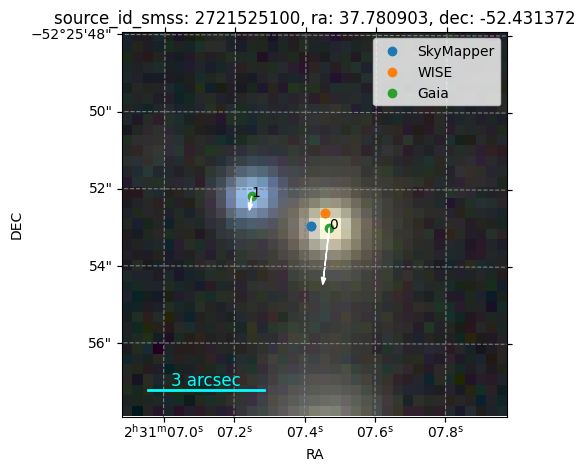

In [ ]:
if hdul_g is not None:
    target_wcs = WCS(hdul_g[0].header)
elif hdul_r is not None:
    target_wcs = WCS(hdul_r[0].header)
elif hdul_i is not None:
    target_wcs = WCS(hdul_i[0].header) 

ra = gr.get_group(source_id_smss).ra_smss.values[0]
dec = gr.get_group(source_id_smss).dec_smss.values[0]
coords = SkyCoord(ra=ra, dec=dec, unit='deg')
size = (10 * u.arcsec, 10 * u.arcsec)

# Reproject the images to a common WCS
# Create cutouts for g, r, and i bands
# Scale the images
if hdul_g is not None:
    reprojected_data_g, _ = reproject_interp(hdul_g, target_wcs)
    hdul_cut_g = Cutout2D(reprojected_data_g, coords, size=size, wcs=target_wcs)
    image_g = hdul_cut_g.data - np.median(hdul_cut_g.data)
    image_g = (image_g - np.min(image_g)) / (np.max(image_g) - np.min(image_g))
    image_g
else:
    image_g = np.zeros((37, 37))

if hdul_r is not None:
    reprojected_data_r, _ = reproject_interp(hdul_r, target_wcs)
    hdul_cut_r = Cutout2D(reprojected_data_r, coords, size=size, wcs=target_wcs)
    image_r = hdul_cut_r.data - np.median(hdul_cut_r.data)
    image_r = (image_r - np.min(image_r)) / (np.max(image_r) - np.min(image_r))
else:
    image_r = np.zeros((37, 37))

if hdul_i is not None:
    reprojected_data_i, _ = reproject_interp(hdul_i, target_wcs)
    hdul_cut_i = Cutout2D(reprojected_data_i, coords, size=size, wcs=target_wcs)
    image_i = hdul_cut_i.data - np.median(hdul_cut_i.data)
    image_i = (image_i - np.min(image_i)) / (np.max(image_i) - np.min(image_i))
else:
    image_i = np.zeros((37, 37))

if hdul_g is not None:
    w_cut = hdul_cut_g.wcs
elif hdul_r is not None:
    w_cut = hdul_cut_r.wcs
elif hdul_i is not None:
    w_cut = hdul_cut_i.wcs

# Plot the cutout images

img_stack = np.stack(
    [
        np.sqrt(image_i),
        np.sqrt(image_r),
        np.sqrt(image_g)
     ], 
     axis=-1)

# img_stack = make_lupton_rgb(image_i, image_r, image_g, stretch=0.1, Q=1)

plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1,1,1, projection=w_cut)
# norm = simple_norm(img_stack, 'sqrt', percent=99.)
cb = ax1.imshow(img_stack, origin='lower')
ax1.coords.grid(color='white', linestyle='solid')
ax1.coords['ra'].set_axislabel('RA')
ax1.coords['dec'].set_axislabel('DEC')
ax1.set_title(f'source_id_smss: {source_id_smss}, ra: {ra:.6f}, dec: {dec:.6f}')
plt.grid(True, color='gray', linestyle='--')
# plt.colorbar(cb)

ax1.scatter(group['ra_smss'], group['dec_smss'], label='SkyMapper',
            transform=ax1.get_transform('icrs'))
ax1.scatter(group['ra_wise'], group['dec_wise'], label='WISE',
            transform=ax1.get_transform('icrs'))
ax1.scatter(group['ra_gaia'], group['dec_gaia'], label='Gaia',
            transform=ax1.get_transform('icrs'))
for i in range(len(group)):
    ax1.arrow(group['ra_gaia'].values[i], group['dec_gaia'].values[i], 
                group['pmra'].values[i]/3600/np.cos(np.deg2rad(group['dec_gaia'].values[i])), 
                group['pmdec'].values[i]/3600,
                width=0.000001,
                head_width=0.00005, 
                head_length=0.00005,
                fc='w', ec='w',
                transform=ax1.get_transform('icrs')
                )
    ax1.annotate(i, (group['ra_gaia'].values[i], group['dec_gaia'].values[i]),
                 xycoords=ax1.get_transform('icrs'))

scale = w_cut.pixel_scale_matrix[1, 1] * 3600
ax1.plot([2, 2 + 3.0/scale], [2, 2], color='cyan', lw=2)
ax1.text(2 + 3.0/scale/2, 3, '3 arcsec', color='cyan', fontsize=12, va='center', ha='center')
plt.legend()

plt.show()



# # Plot the reprojected images
# plt.figure(figsize=(10, 5))
# for i, data in enumerate([reprojected_data_g, reprojected_data_r, reprojected_data_i]):
#     plt.subplot(1, 3, i+1)
#     norm = simple_norm(data, 'sqrt', percent=99.)
#     plt.imshow(data, origin='lower', cmap='gray', norm=norm)
#     plt.title('griz'[i])
#     plt.axis('off')
# plt.show()


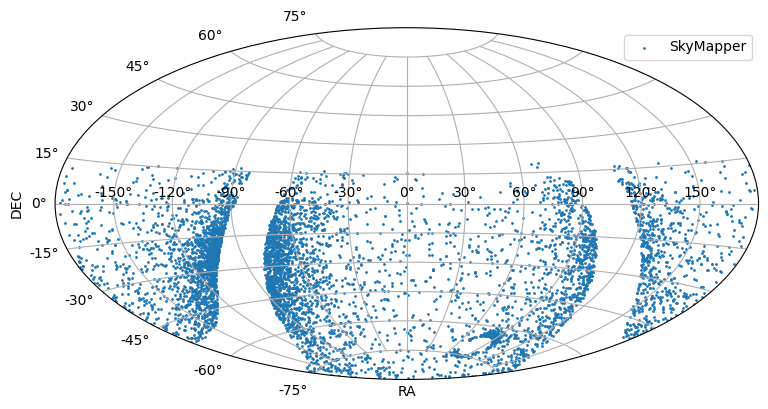

In [ ]:
df = gr.first()
plt.figure(figsize=(15, 8))
ax = plt.subplot(121, projection="aitoff")
coords = SkyCoord(ra=df['ra_smss'], dec=df['dec_smss'], unit=(u.deg, u.deg))
ax.scatter(coords.ra.wrap_at(180 * u.deg).radian, coords.dec.radian, 
           label='SkyMapper', s=1)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


# Fitting

In [2]:
df_candidates = pd.read_csv('./data/candidates/candidates2.csv')
gr = df_candidates.groupby('source_id_smss')
len(gr)

13576

In [ ]:
# source_id = 17421497
# source_id = 2868665
source_id = 28242185
source_id = 487280214
source_id = 5584603
source_id = 453293982
source_id = 461905962
source_id = 1618067076 # !
source_id = 483230241 # !
source_id = 404479007
source_id = 409098648
source_id = 461882680
source_id = 485027609
source_id = 491157088
source_id = 1497550537
source_id = 1498247970
source_id = 1563174623
source_id = 1604120794 # !-
source_id = 2585833899
source_id = 491757331

In [16]:
source_id = 487739096
source_id = 83940274
# source_id = 
source_id = 101905779 # !
source_id = 104154779 # !
source_id = 106687017 # !
source_id = 106898595 # !
source_id = 108005243 # !
source_id = 108636826 # !
source_id = 111184921 # !
source_id = 114576490 # !
source_id = 116642525 # !
source_id = 119099857 # !
source_id = 146602877
source_id = 166608484
source_id = 171027834 # !
source_id = 171187847
source_id = 172724142 # !
source_id = 196276991
source_id = 407431103
source_id = 409568621
source_id = 411117261
source_id = 457455068

 id xcentroid ycentroid sharpness roundness1 ...  peak flux  mag   daofind_mag
--- --------- --------- --------- ---------- ... ----- ---- ------ -----------
  1     53.28     52.68     0.387     0.2334 ...   192 3267 -8.785    -0.02247
  2     47.99     57.06    0.5201     0.0485 ... 252.8 3564  -8.88     -0.4977
  3     55.74     57.48    0.3682  -0.005916 ... 291.2 5392 -9.329     -0.2831
(array([52.63283388, 47.41148331]), array([52.46979689, 57.4261413 ]))
Source 0 is in Gaia
Source 1 is in Gaia
Added 1 sources


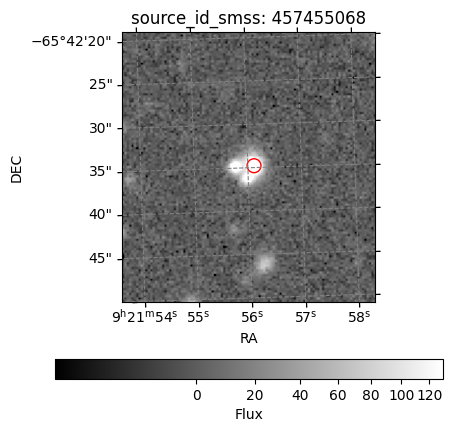

In [20]:
group = gr.get_group(source_id)
band = 'r'
hdul_r = fits.open(f"data/candidates/fits2/{band}/{source_id}_{band}.fits")
w_r = WCS(hdul_r[0].header)
data_r = hdul_r[0].data
header_r = hdul_r[0].header
hdul_r.close()

mean, median, std = sigma_clipped_stats(data_r, sigma=3.0)  
daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)  
data_r -= median
sources = daofind(data_r)
for col in sources.colnames:  
    sources[col].info.format = '%.4g'
print(sources)
x_centroid = np.array(sources['xcentroid'])
y_centroid = np.array(sources['ycentroid'])

gaia_pix = w_r.world_to_pixel_values(group['ra_gaia'], group['dec_gaia'])
print(gaia_pix)

addsources = []
for i, (x, y) in enumerate(zip(x_centroid, y_centroid)):
    if np.any(np.sqrt((x - gaia_pix[0])**2 + (y - gaia_pix[1])**2) < 4):
        print(f"Source {i} is in Gaia")
    else:
        addsources.append(sources[i])
print(f"Added {len(addsources)} sources")

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection=w_r)
norm = simple_norm(data_r, 'sqrt', percent=99.)
cb = ax.imshow(data_r, origin='lower', cmap='gray', norm=norm)
for source in addsources:
    ax.scatter(source['xcentroid'], source['ycentroid'], s=100, edgecolor='red', facecolor='none',
               transform=ax.get_transform(w_r))
ax.coords.grid(color='white', linestyle='solid')
ax.coords['ra'].set_axislabel('RA')
ax.coords['dec'].set_axislabel('DEC')
ax.set_title(f'source_id_smss: {source_id}')
plt.grid(True, color='gray', linestyle='--')
plt.colorbar(cb, label='Flux', orientation='horizontal')
plt.show()

In [21]:
gaia_pix = w_r.world_to_pixel_values(group['ra_gaia'], group['dec_gaia'])
fit_r = fitting.LevMarLSQFitter()
model_init = models.Const2D(amplitude=0.0,
                            fixed={'amplitude': True}
                            )

# Gaia sources
for i in range(len(group)):
    model_init += models.Moffat2D(amplitude=data_r[int(gaia_pix[0][i]), int(gaia_pix[1][i])],
                                    x_0=gaia_pix[0][i], y_0=gaia_pix[1][i],
                                    gamma=2.0, alpha=2.5,
                                    fixed={'alpha': True,
                                        #    'gamma': True,
                                           },
                                    # bounds={'gamma': (0.5, 5)}
                                    )

def tie_gamma(model):
    return model.gamma_1
model_init[2].gamma.tied = tie_gamma
# model_init[3].gamma.tied = tie_gamma

# Galaxy
# g_x, g_y = (gaia_pix[0][0] + gaia_pix[0][1])/2, (gaia_pix[1][0] + gaia_pix[1][1])/2
# model_init += models.Gaussian2D(amplitude=data_r[int(g_x), int(g_y)]/2,
#                                 x_mean=g_x, y_mean=g_y, x_stddev=3, y_stddev=3)

# Additional sources
# for i, source in enumerate(addsources):
#     model_init += models.Gaussian2D(amplitude=source['peak'], 
#                                     x_mean=source['xcentroid'], y_mean=source['ycentroid'], 
#                                     x_stddev=2, y_stddev=2)
    
# Fit the model to the data
y, x = np.mgrid[:data_r.shape[0], :data_r.shape[1]]
model_r = fit_r(model_init, x, y, data_r)
print(model_r)

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const2D(amplitude=0.)>

    [1]: <Moffat2D(amplitude=-175.1485301, x_0=58.01142381, y_0=54.61967582, gamma=8.1792782, alpha=2.5)>

    [2]: <Moffat2D(amplitude=372.76906215, x_0=55.65741696, y_0=55.95787613, gamma=8.1792782, alpha=2.5)>
Parameters:
    amplitude_0    amplitude_1           x_0_1       ...      gamma_2      alpha_2
    ----------- ------------------ ----------------- ... ----------------- -------
            0.0 -175.1485300969388 58.01142381054128 ... 8.179278204380983     2.5


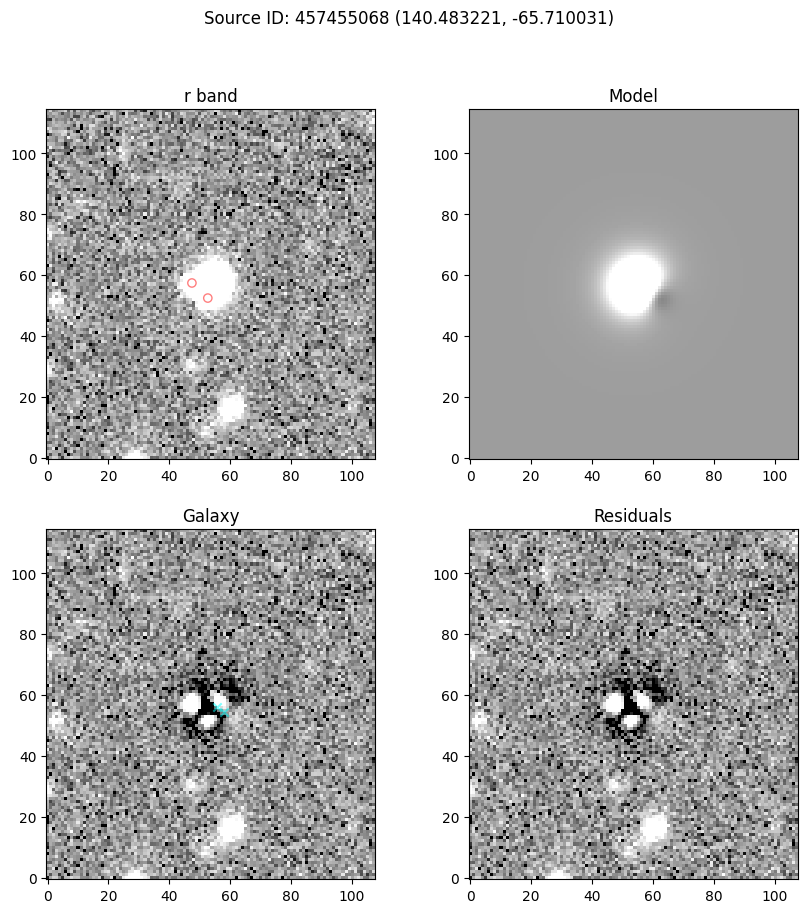

140.483221, -65.710031


In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
norm = simple_norm(data_r, 'sqrt', percent=95.0)
plt.imshow(data_r, origin='lower', cmap='gray', norm=norm)
for i in range(len(group)):
    plt.scatter(gaia_pix[0][i], gaia_pix[1][i], label='Gaia', 
                color='r', facecolors='none', alpha=0.5)
plt.title(f'{band} band')
plt.subplot(222)
plt.imshow(model_r(x, y), origin='lower', cmap='gray', norm=norm)
plt.title('Model')
plt.subplot(223)
plt.imshow(data_r - model_r[:3](x, y), origin='lower', cmap='gray', norm=norm)
# for i in range(len(group)):
#     plt.scatter(gaia_pix[0][i], gaia_pix[1][i], label='Gaia', 
#                 color='r', 
#                 facecolors='none', 
#                 alpha=0.5, 
#                 # marker='x'
#                 )
    
for i, model in enumerate(model_r[:]):
    # print(model)
    if i == 0:
        continue
    elif (i == 1) or (i == 2):
        plt.scatter(model.x_0.value, model.y_0.value, label='Component', 
                    color='cyan', 
                    # facecolors='none', 
                    alpha=0.5, 
                    marker='x'
                    )    
    else:
        plt.scatter(model.x_mean.value, model.y_mean.value, label='Galaxy', 
                    color='red', 
                    # facecolors='none', 
                    alpha=0.5, 
                    marker='x'
                    )

plt.title('Galaxy')

plt.subplot(224)
plt.imshow(data_r - model_r[:](x, y), origin='lower', cmap='gray', norm=norm)
plt.title('Residuals')
plt.suptitle(f"Source ID: {source_id} ({group.iloc[0]['ra_gaia']:.6f}, {group.iloc[0]['dec_gaia']:.6f})")
plt.savefig(f'figs/model_{source_id}.png', bbox_inches='tight', facecolor='w', edgecolor='w')
plt.show()
print(f"{group.iloc[0]['ra_gaia']:.6f}, {group.iloc[0]['dec_gaia']:.6f}")

# Map

In [10]:
selected_gr = gr.filter(lambda x: len(x) >= 2)
ra_candidate, dec_candidate = 110.677, -39.0332

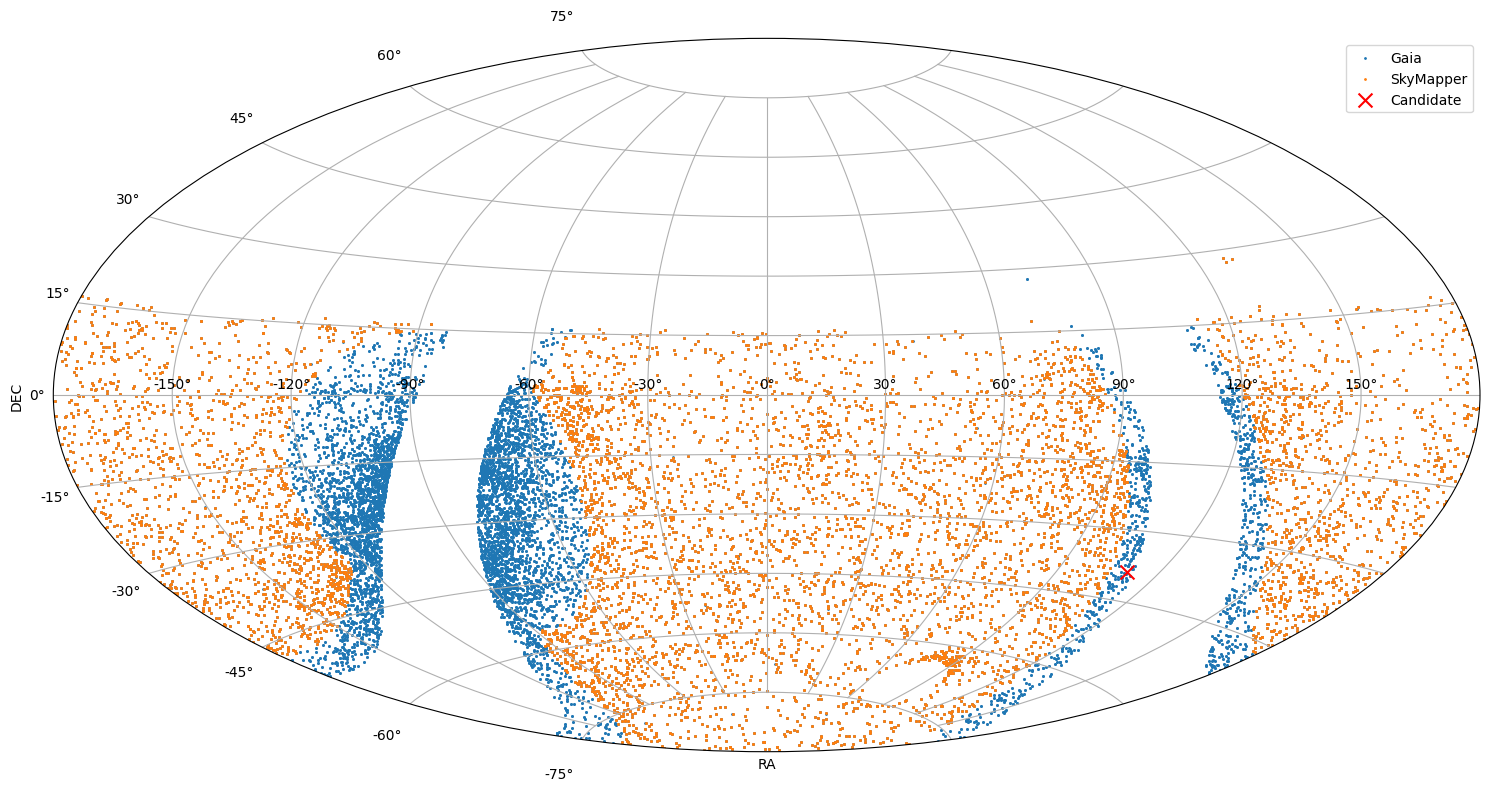

14556

In [11]:
# df = gr.first()
df = selected_gr.copy()
plt.figure(figsize=(15, 8))
ax = plt.subplot(111, 
                 projection="aitoff"
                 )
coords = SkyCoord(ra=df.loc[:, 'ra_gaia'],
                    dec=df.loc[:, 'dec_gaia'],
                    unit=(u.deg, u.deg))
ax.scatter(coords.ra.wrap_at(180 * u.deg).radian, coords.dec.radian,
            label='Gaia', s=1)
# Calculate the condition
cond = np.cos(np.deg2rad(df['glat'])+np.deg2rad(0)) * np.cos(np.deg2rad(df['glon']) - np.deg2rad(10)) \
    < np.cos(np.radians(35))
cond = np.logical_and(cond, df['glat'].abs() > 15)
coords = SkyCoord(ra=df.loc[cond, 'ra_smss'], 
                  dec=df.loc[cond, 'dec_smss'], 
                  unit=(u.deg, u.deg))
ax.scatter(coords.ra.wrap_at(180 * u.deg).radian, coords.dec.radian, 
           label='SkyMapper', s=1)
coord_candidate = SkyCoord(ra=ra_candidate, dec=dec_candidate, unit=(u.deg, u.deg))
ax.scatter(coord_candidate.ra.wrap_at(180 * u.deg).radian, coord_candidate.dec.radian,
              label='Candidate', s=100, marker='x', color='red')

ax.set_xlabel('RA') 
ax.set_ylabel('DEC')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()
len(df[cond])

In [170]:
df.groupby('source_id_smss').size().sort_values(ascending=False).tail(70)

source_id_smss
86410090      3
169536558     3
172066925     3
260511549     3
229297520     3
             ..
206004128     3
206507581     3
206685126     3
206848287     3
2720658394    3
Length: 70, dtype: int64

In [17]:
(gr.size()>2).sum()

np.int64(301)

# Size distribution

In [ ]:
df_candidates = pd.read_csv('./data/candidates/candidates2.csv')
gr = df_candidates.groupby('source_id_smss')
len(gr)

13576

In [ ]:
def get_min_separation(x):
    coords = SkyCoord(ra=x['ra_gaia'], dec=x['dec_gaia'], unit=(u.deg, u.deg))
    _, d2d, _ = coords.match_to_catalog_sky(coords, nthneighbor=2)
    return min(d2d.to(u.arcsec).value)

def get_max_separation(x):
    coords = SkyCoord(ra=x['ra_gaia'], dec=x['dec_gaia'], unit=(u.deg, u.deg))
    _, d2d, _ = coords.match_to_catalog_sky(coords, nthneighbor=2)
    return max(d2d.to(u.arcsec).value)

min_sep = gr.apply(get_min_separation)
max_sep = gr.apply(get_max_separation)

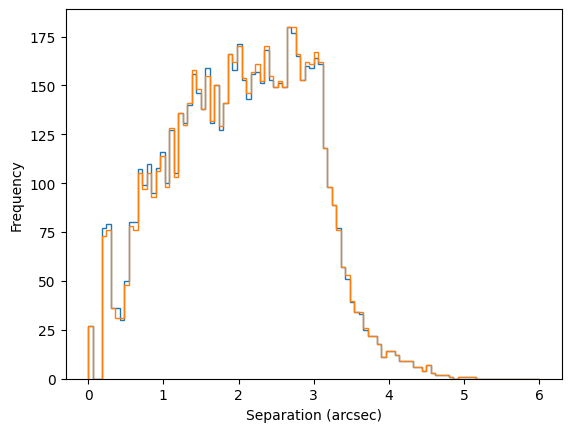

In [ ]:
nrange = (0, 6)
nbins = 100
plt.figure()
plt.hist(min_sep, bins=nbins, range=nrange, histtype='step', label='Min separation')
plt.hist(max_sep, bins=nbins, range=nrange, histtype='step', label='Max separation')
plt.xlabel('Separation (arcsec)')
plt.ylabel('Frequency')
plt.show()